#Load Modules

In [1]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.metrics import classification_report

import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from os.path import exists

#Directory Structure

In [ ]:
# Create a new directory
base_dir = '/content/drive/MyDrive/Datasets/base_dir'

if not exists(base_dir):
    os.mkdir(base_dir)

    # now we create 7 folders inside 'base_dir':
    # train_dir
        # nv
        # mel
        # bkl
        # bcc
        # akiec
        # vasc
        # df
    
    # val_dir
        # nv
        # mel
        # bkl
        # bcc
        # akiec
        # vasc
        # df

    # create a path to 'base_dir' to which we will join the names of the new folders
    # train_dir
    train_dir = os.path.join(base_dir, 'train_dir')
    os.mkdir(train_dir)

    # create new folders inside train_dir
    nv = os.path.join(train_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(train_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(train_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(train_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(train_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(train_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(train_dir, 'df')
    os.mkdir(df)

    # val_dir
    val_dir = os.path.join(base_dir, 'val_dir')
    os.mkdir(val_dir)

    # create new folders inside val_dir
    nv = os.path.join(val_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(val_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(val_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(val_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(val_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(val_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(val_dir, 'df')
    os.mkdir(df)
  
   # val_dir
    test_dir = os.path.join(base_dir, 'test_dir')
    os.mkdir(test_dir)
   # create new folders inside val_dir
    nv = os.path.join(test_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(test_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(test_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(test_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(test_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(test_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(test_dir, 'df')
    os.mkdir(df)

#Load MetaData

In [ ]:
df_data = pd.read_csv('/content/drive/MyDrive/Datasets/HAM10000_metadata')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
df_data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,dataset
count,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,vidir_molemax
freq,6,1,6705,5340,5406,2192,3954


#Exploratory Data Analysis (EDA)

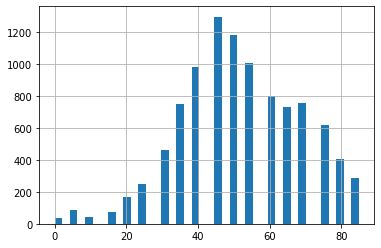

In [ ]:
df_data['age'].hist(bins=40)

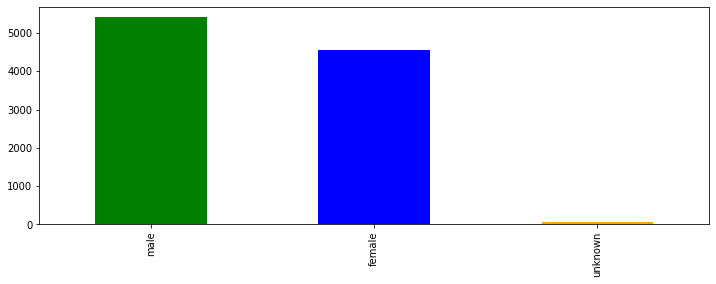

In [ ]:
plt.figure(figsize=(12, 4))
df_data['sex'].value_counts().plot(kind='bar', color=['green', "blue", "orange"])

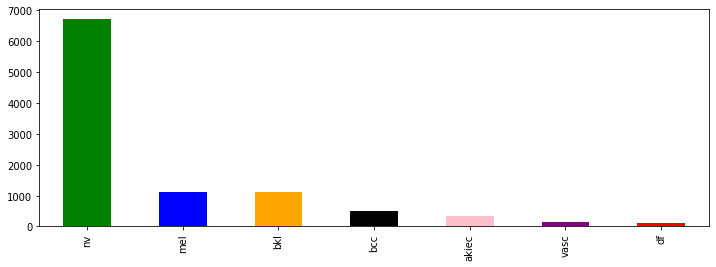

In [ ]:
plt.figure(figsize=(12, 4))
df_data['dx'].value_counts().plot(kind='bar', color=["green", "blue", "orange", "black", "pink", "purple", "red"])

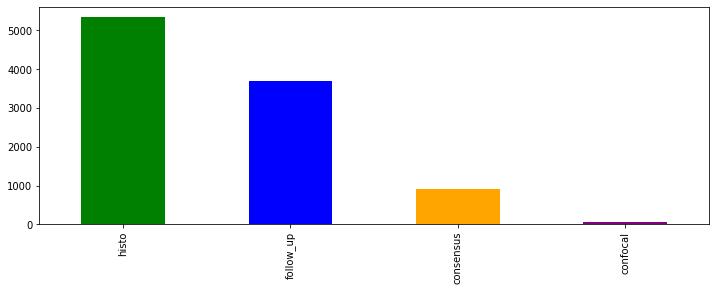

In [ ]:
plt.figure(figsize=(12, 4))
df_data['dx_type'].value_counts().plot(kind='bar', color=["green", "blue", "orange", "purple"])

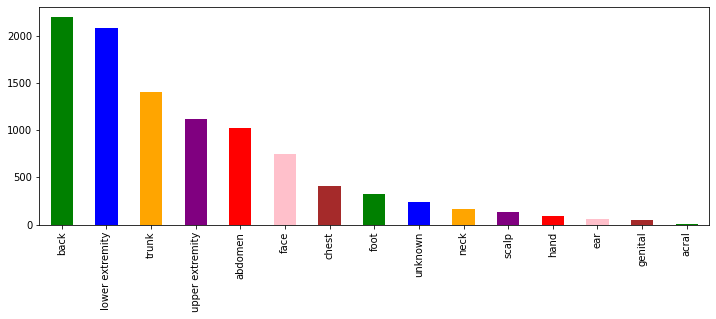

In [ ]:
plt.figure(figsize=(12, 4))
df_data['localization'].value_counts().plot(kind='bar', color=["green", "blue", "orange", "purple", "red", "pink", "brown"])

#Checking Duplicate images

In [ ]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1


#Seven types of symbols 

In [ ]:
df_data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates


In [ ]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [ ]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 9)

#Seven types of symbols without duplicate images

In [ ]:
df['dx'].value_counts()

nv       4415
bkl       440
mel       230
bcc       175
akiec     151
vasc       64
df         39
Name: dx, dtype: int64

In [ ]:
# now we create a val set using df because we are sure that none of these images
y = df['dx']

_, df_val = train_test_split(df, test_size=0.545, random_state=101, stratify=y)

df_val.shape

(3006, 9)

#Create a train set 

In [ ]:
# This set will be df_data excluding all rows that are in the val set
def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

7009
3006


In [ ]:
df_train['dx'].value_counts()

nv       4298
mel       988
bkl       859
bcc       418
akiec     245
vasc      107
df         94
Name: dx, dtype: int64

#Create Validation and Test Set

In [ ]:
# now we create a val set using df because we are sure that none of these images
y = df_val['dx']

df_val, df_test = train_test_split(df_val, test_size=0.666, random_state=101, stratify=y)

df_test.shape

(2002, 9)

In [ ]:
df_val['dx'].value_counts()

nv       804
bkl       80
mel       42
bcc       32
akiec     27
vasc      12
df         7
Name: dx, dtype: int64

In [ ]:
df_val.shape

(1004, 9)

In [ ]:
df_test['dx'].value_counts()

nv       1603
bkl       160
mel        83
bcc        64
akiec      55
vasc       23
df         14
Name: dx, dtype: int64

#Transfer Images into the Folders

In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [2]:
train_path = '/content/drive/MyDrive/Datasets/base_dir/train_dir'
valid_path = '/content/drive/MyDrive/Datasets/base_dir/val_dir'
test_path = '/content/drive/MyDrive/Datasets/base_dir/test_dir'

In [ ]:
# # Get a list of images in each of the two folders
# folder_1 = os.listdir('/content/drive/MyDrive/Datasets/HAM10000_images_part_1')
# folder_2 = os.listdir('/content/drive/MyDrive/Datasets/HAM10000_images_part_2')

# # Get a list of train and val images
# train_list = list(df_train['image_id'])
# val_list = list(df_val['image_id'])
# test_list = list(df_test['image_id'])

# # Transfer the training images

# for image in train_list:
    
#     fname = image + '.jpg'
#     label = df_data.loc[image,'dx']
    
#     if fname in folder_1:
#         src = os.path.join('/content/drive/MyDrive/Datasets/HAM10000_images_part_1', fname)
#         dst = os.path.join(train_path, label, fname)
#         if not exists(dst):
#           shutil.copyfile(src, dst)

#     if fname in folder_2:
#         src = os.path.join('/content/drive/MyDrive/Datasets/HAM10000_images_part_2', fname)
#         dst = os.path.join(train_path, label, fname)
#         if not exists(dst):
#           shutil.copyfile(src, dst)

# # Transfer the validation images
# for image in val_list:
    
#     fname = image + '.jpg'
#     label = df_data.loc[image,'dx']
    
#     if fname in folder_1:
#         src = os.path.join('/content/drive/MyDrive/Datasets/HAM10000_images_part_1', fname)
#         dst = os.path.join(valid_path, label, fname)
#         if not exists(dst):
#           shutil.copyfile(src, dst)

#     if fname in folder_2:
#         src = os.path.join('/content/drive/MyDrive/Datasets/HAM10000_images_part_2', fname)
#         dst = os.path.join(valid_path, label, fname)
#         if not exists(dst):
#           shutil.copyfile(src, dst)

# # Transfer the Test images
# for image in test_list:
    
#     fname = image + '.jpg'
#     label = df_data.loc[image,'dx']
    
#     if fname in folder_1:
#         src = os.path.join('/content/drive/MyDrive/Datasets/HAM10000_images_part_1', fname)
#         dst = os.path.join(test_path, label, fname)
#         if not exists(dst):
#           shutil.copyfile(src, dst)

#     if fname in folder_2:
#         src = os.path.join('/content/drive/MyDrive/Datasets/HAM10000_images_part_2', fname)
#         dst = os.path.join(test_path, label, fname)
#         if not exists(dst):
#           shutil.copyfile(src, dst)
        


In [ ]:
# check how many train images we have in each folder


print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/train_dir/nv'))) # 5
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/train_dir/mel'))) # 4
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/train_dir/bkl'))) # 2
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/train_dir/bcc'))) # 1
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/train_dir/akiec'))) # 0
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/train_dir/vasc'))) # 6
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/train_dir/df'))) # 3

4298
988
859
418
245
107
94


In [ ]:
# check how many validation images we have in each folder


print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/val_dir/nv'))) # 5
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/val_dir/mel'))) # 4
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/val_dir/bkl'))) # 2
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/val_dir/bcc'))) # 1
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/val_dir/akiec'))) # 0
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/val_dir/vasc'))) # 6
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/val_dir/df'))) # 3

804
42
80
32
27
12
7


In [ ]:
# check how many test images we have in each folder

print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/test_dir/nv'))) # 5
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/test_dir/mel'))) # 4
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/test_dir/bkl'))) # 2
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/test_dir/bcc'))) # 1
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/test_dir/akiec'))) # 0
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/test_dir/vasc'))) # 6
print(len(os.listdir('/content/drive/MyDrive/Datasets/base_dir/test_dir/df'))) # 3

1603
83
160
64
55
23
14


#Set Up the Generators

In [3]:
num_train_samples = 7009#len(df_train)
num_val_samples = 1004#len(df_val)
train_batch_size = 32
val_batch_size = 32
image_size = 64

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
print(len(df_train))
print(len(df_val))

7009
1004


# Augmented Data

In [11]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last')

#Create a CNN Model

In [ ]:
inputs=Input((image_size, image_size, 3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation="softmax")(x)
    
model1 = Model(inputs, outputs)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                             

#Create a pre-traing transfer learning model vgg16

In [ ]:
basemodel = VGG16(input_shape=(image_size, image_size, 3), include_top = False)
basemodel.summary()
    
for layer in basemodel.layers:
    layer.trainable = False
     
inputs = basemodel.input   
x = basemodel.output
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation="softmax")(x)
model2 = Model(inputs, outputs)
model2.summary()
    

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

#Create a pre-traing transfer learning model MobileNet

In [ ]:
basemodel = MobileNetV2(input_shape=(image_size, image_size, 3), include_top = False)
basemodel.summary()

inputs = basemodel.input;
x = basemodel.layers[-6].output
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation = 'sigmoid')(x)
outputs = Dense(7, activation='softmax')(x)
model3 = Model(inputs, outputs)
model3.summary()

for layer in basemodel.layers[:-23]:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                

# Create a pre-traing transfer learning model ResNet152V2

In [ ]:
basemodel = ResNet152V2(input_shape=(image_size, image_size, 3), include_top = False)
basemodel.summary()

for layer in basemodel.layers:
    layer.trainable = False

inputs = basemodel.input   
x = basemodel.output
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation="softmax")(x)

model4 = Model(inputs, outputs)
model4.summary()

234561536/234545216 [==============================] - 2s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                     

In [12]:
train_batches = augmented_data.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = augmented_data.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = augmented_data.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 7009 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [13]:
train_labels = train_batches.classes
valid_labels = valid_batches.classes
test_labels = test_batches.classes

# Class Weights

In [14]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 4.086880466472303,
 1: 2.3954203691045794,
 2: 1.1656411109263263,
 3: 10.651975683890578,
 4: 1.0134470792365529,
 5: 0.23296549890314433,
 6: 9.357810413885181}

#Train AM-12 Model

In [ ]:
# Train model
model1.compile(loss = 'categorical_crossentropy', metrics=['accuracy', 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history1 = model1.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=20)

Epoch 1/20
220/220 [==============================] - 507s 2s/step - loss: 1.3478 - accuracy: 0.6085 - mse: 0.0878 - val_loss: 0.8859 - val_accuracy: 0.8008 - val_mse: 0.0552
Epoch 2/20
220/220 [==============================] - 492s 2s/step - loss: 1.2313 - accuracy: 0.6129 - mse: 0.0817 - val_loss: 0.8628 - val_accuracy: 0.8008 - val_mse: 0.0537
Epoch 3/20
220/220 [==============================] - 491s 2s/step - loss: 1.2018 - accuracy: 0.6125 - mse: 0.0803 - val_loss: 0.9486 - val_accuracy: 0.8008 - val_mse: 0.0625
Epoch 4/20
220/220 [==============================] - 489s 2s/step - loss: 1.1237 - accuracy: 0.6121 - mse: 0.0760 - val_loss: 0.8246 - val_accuracy: 0.8008 - val_mse: 0.0519
Epoch 5/20
220/220 [==============================] - 487s 2s/step - loss: 1.0842 - accuracy: 0.6126 - mse: 0.0742 - val_loss: 0.7203 - val_accuracy: 0.8008 - val_mse: 0.0451
Epoch 6/20
220/220 [==============================] - 489s 2s/step - loss: 1.0595 - accuracy: 0.6159 - mse: 0.0722 - val_loss

In [ ]:
model1.save('/content/drive/MyDrive/Datasets/model1_50epochs.h5')

In [9]:
model1 = load_model('/content/drive/MyDrive/Datasets/model1_50epochs.h5')

In [15]:
test_loss, test_accuracy, test_mse = model1.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

2002/2002 [==============================] - 36s 18ms/step - loss: 0.5592 - accuracy: 0.8152 - mse: 0.0356

Test Set Accuracy:  81.51848316192627 % 
Test Set Loss: 0.5591529607772827 
Test Set MSE: 0.035580702126026154


In [16]:
predictions1 = model1.predict(test_batches, verbose=1)
print(predictions1.shape)
pre_labels = np.argmax(predictions1, axis = 1) 
print(classification_report(test_labels, pre_labels))

2002/2002 [==============================] - 34s 17ms/step
(2002, 7)
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        55
           1       0.00      0.00      0.00        64
           2       0.41      0.19      0.26       160
           3       0.00      0.00      0.00        14
           4       0.31      0.10      0.15        83
           5       0.84      1.00      0.91      1603
           6       0.00      0.00      0.00        23

    accuracy                           0.82      2002
   macro avg       0.37      0.19      0.20      2002
weighted avg       0.75      0.82      0.76      2002



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train VGG16 Model

In [5]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.vgg16.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 7009 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [ ]:
# Train model
model2.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history2 = model2.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=50)

Epoch 1/50
220/220 [==============================] - 3772s 17s/step - loss: 0.9256 - accuracy: 0.5633 - mse: 0.0778 - val_loss: 0.8510 - val_accuracy: 0.7112 - val_mse: 0.0565
Epoch 2/50
220/220 [==============================] - 313s 1s/step - loss: 0.8726 - accuracy: 0.5691 - mse: 0.0776 - val_loss: 0.7347 - val_accuracy: 0.7390 - val_mse: 0.0490
Epoch 3/50
220/220 [==============================] - 306s 1s/step - loss: 0.8668 - accuracy: 0.5734 - mse: 0.0768 - val_loss: 0.8385 - val_accuracy: 0.7151 - val_mse: 0.0553
Epoch 4/50
220/220 [==============================] - 310s 1s/step - loss: 0.8166 - accuracy: 0.5962 - mse: 0.0716 - val_loss: 0.7386 - val_accuracy: 0.7390 - val_mse: 0.0501
Epoch 5/50
220/220 [==============================] - 305s 1s/step - loss: 0.7557 - accuracy: 0.6048 - mse: 0.0703 - val_loss: 0.6220 - val_accuracy: 0.7829 - val_mse: 0.0421
Epoch 6/50
220/220 [==============================] - 312s 1s/step - loss: 0.6796 - accuracy: 0.6241 - mse: 0.0677 - val_lo

In [ ]:
model2.save('/content/drive/MyDrive/Datasets/model2_50epochs.h5')

In [4]:
model2 = load_model('/content/drive/MyDrive/Datasets/model2_50epochs.h5')

In [6]:
test_loss, test_accuracy, test_mse = model2.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

2002/2002 [==============================] - 474s 233ms/step - loss: 0.8376 - accuracy: 0.7807 - mean_squared_error: 0.0461

Test Set Accuracy:  78.07192802429199 % 
Test Set Loss: 0.8375656604766846 
Test Set MSE: 0.04612540826201439


In [8]:
predictions2 = model2.predict(test_batches, verbose=1)
print(predictions2.shape)
test_labels = test_batches.classes
pre_labels = np.argmax(predictions2, axis = 1) 
print(classification_report(test_labels, pre_labels))

2002/2002 [==============================] - 41s 20ms/step
(2002, 7)
              precision    recall  f1-score   support

           0       0.34      0.33      0.33        55
           1       0.43      0.61      0.51        64
           2       0.34      0.47      0.39       160
           3       0.21      0.36      0.26        14
           4       0.23      0.40      0.29        83
           5       0.95      0.86      0.90      1603
           6       0.74      0.61      0.67        23

    accuracy                           0.78      2002
   macro avg       0.46      0.52      0.48      2002
weighted avg       0.83      0.78      0.80      2002



# Train MobileNetV2 Model

In [17]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 7009 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [ ]:
# Train model
model3.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history3 = model3.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=20)

Epoch 1/20
220/220 [==============================] - 134s 593ms/step - loss: 1.5903 - accuracy: 0.3757 - mse: 0.1058 - val_loss: 1.3576 - val_accuracy: 0.3785 - val_mse: 0.1017
Epoch 2/20
220/220 [==============================] - 127s 578ms/step - loss: 1.2155 - accuracy: 0.5222 - mse: 0.0883 - val_loss: 1.0662 - val_accuracy: 0.5637 - val_mse: 0.0787
Epoch 3/20
220/220 [==============================] - 122s 555ms/step - loss: 1.0310 - accuracy: 0.5654 - mse: 0.0810 - val_loss: 1.1259 - val_accuracy: 0.5538 - val_mse: 0.0804
Epoch 4/20
220/220 [==============================] - 122s 552ms/step - loss: 0.9427 - accuracy: 0.5989 - mse: 0.0759 - val_loss: 1.0123 - val_accuracy: 0.6454 - val_mse: 0.0724
Epoch 5/20
220/220 [==============================] - 121s 550ms/step - loss: 0.8640 - accuracy: 0.6269 - mse: 0.0720 - val_loss: 0.8801 - val_accuracy: 0.6683 - val_mse: 0.0640
Epoch 6/20
220/220 [==============================] - 123s 558ms/step - loss: 0.7821 - accuracy: 0.6348 - mse:

In [ ]:
model3.save('/content/drive/MyDrive/Datasets/model3_50epochs.h5')

In [18]:
model3 = load_model('/content/drive/MyDrive/Datasets/model3_50epochs.h5')

In [19]:
test_loss, test_accuracy, test_mse = model3.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

2002/2002 [==============================] - 39s 19ms/step - loss: 0.7811 - accuracy: 0.7862 - mse: 0.0474

Test Set Accuracy:  78.62138152122498 % 
Test Set Loss: 0.7811161875724792 
Test Set MSE: 0.04742864519357681


In [20]:
predictions3 = model3.predict(test_batches,  verbose=1)
print(predictions3.shape)
pre_labels = np.argmax(predictions3, axis = 1) 
print(classification_report(test_labels, pre_labels))

2002/2002 [==============================] - 38s 18ms/step
(2002, 7)
              precision    recall  f1-score   support

           0       0.23      0.20      0.21        55
           1       0.23      0.81      0.36        64
           2       0.46      0.40      0.43       160
           3       0.11      0.21      0.15        14
           4       0.38      0.27      0.31        83
           5       0.95      0.88      0.91      1603
           6       0.94      0.65      0.77        23

    accuracy                           0.79      2002
   macro avg       0.47      0.49      0.45      2002
weighted avg       0.84      0.79      0.80      2002



# Train ResNet152V2 Model

In [21]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.resnet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 7009 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [ ]:
# Train model
model4.compile(loss = 'categorical_crossentropy', metrics=['accuracy', 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history4 = model4.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=50)

Epoch 1/50
220/220 [==============================] - 378s 2s/step - loss: 1.8232 - accuracy: 0.3096 - mse: 0.1156 - val_loss: 1.4893 - val_accuracy: 0.4582 - val_mse: 0.0953
Epoch 2/50
220/220 [==============================] - 371s 2s/step - loss: 1.5364 - accuracy: 0.3805 - mse: 0.1049 - val_loss: 1.0549 - val_accuracy: 0.6185 - val_mse: 0.0700
Epoch 3/50
220/220 [==============================] - 367s 2s/step - loss: 1.3235 - accuracy: 0.4330 - mse: 0.0978 - val_loss: 0.9518 - val_accuracy: 0.6414 - val_mse: 0.0642
Epoch 4/50
220/220 [==============================] - 359s 2s/step - loss: 1.1487 - accuracy: 0.4949 - mse: 0.0882 - val_loss: 0.9010 - val_accuracy: 0.6673 - val_mse: 0.0609
Epoch 5/50
220/220 [==============================] - 366s 2s/step - loss: 1.0413 - accuracy: 0.5310 - mse: 0.0843 - val_loss: 1.0072 - val_accuracy: 0.6335 - val_mse: 0.0702
Epoch 6/50
220/220 [==============================] - 370s 2s/step - loss: 0.8965 - accuracy: 0.5420 - mse: 0.0808 - val_loss

In [ ]:
model4.save('/content/drive/MyDrive/Datasets/model4_50epochs.h5')

In [22]:
model4 = load_model('/content/drive/MyDrive/Datasets/model4_50epochs.h5')

In [23]:
test_loss, test_accuracy, test_mse = model4.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

2002/2002 [==============================] - 147s 72ms/step - loss: 0.6723 - accuracy: 0.8107 - mse: 0.0407

Test Set Accuracy:  81.06893301010132 % 
Test Set Loss: 0.6723149418830872 
Test Set MSE: 0.04066969081759453


In [24]:
predictions4 = model4.predict(test_batches, verbose=1)
predictions4.shape

2002/2002 [==============================] - 123s 60ms/step


(2002, 7)

In [25]:
test_labels = test_batches.classes
pre_labels = np.argmax(predictions4, axis = 1) 
print(classification_report(test_labels, pre_labels))

              precision    recall  f1-score   support

           0       0.29      0.31      0.30        55
           1       0.42      0.42      0.42        64
           2       0.43      0.35      0.39       160
           3       0.19      0.21      0.20        14
           4       0.31      0.42      0.36        83
           5       0.92      0.92      0.92      1603
           6       0.42      0.22      0.29        23

    accuracy                           0.81      2002
   macro avg       0.42      0.41      0.41      2002
weighted avg       0.81      0.81      0.81      2002



#Model Name

In [26]:
model1_name = "AM-12"
model2_name = "VGG16"
model3_name = "MobileNetV2"
model4_name = "ResNet152V2"

#Create Confusion Matrix

In [27]:
def create_confusion_matrix(test_labels, predictions, cm_plot_labels, name):
    
    #Compute the confusion matrix
    cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

    #Plot the confusion matrix
    plot_confusion_matrix(cm, cm_plot_labels, name) 

#Plot the confusion matrix for true vs predicted labels

In [28]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt

    if not exists('/content/drive/MyDrive/Datasets/Photos'):
        os.mkdir('/content/drive/MyDrive/Datasets/Photos')
    
    fig.savefig('/content/drive/MyDrive/Datasets/Photos/' + name + '_confusion_matrix.png', dpi=300)

#Testing Set Confusion Matrix for True vs Predicted Labels

In [29]:
print(test_labels)
print(test_batches.class_indices)

[0 0 0 ... 6 6 6]
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


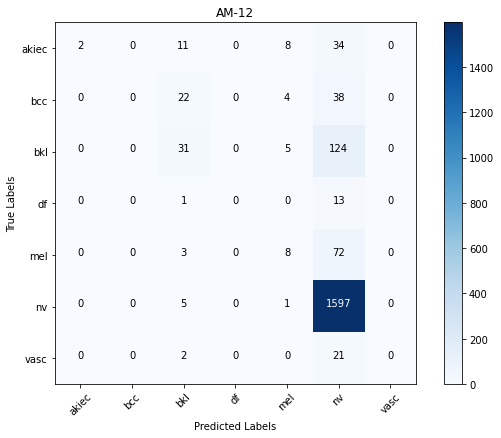

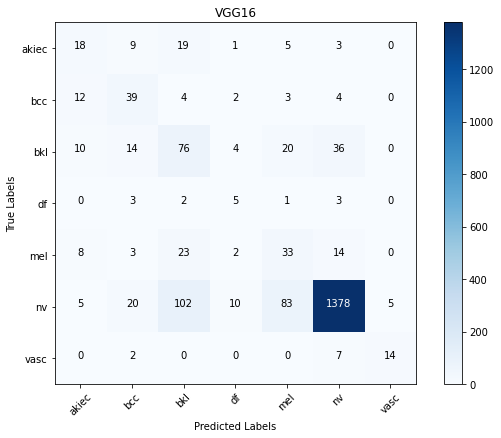

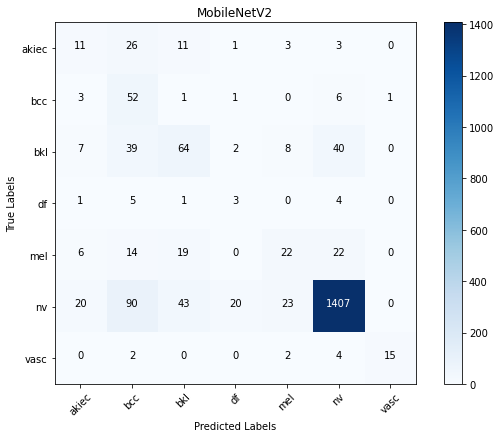

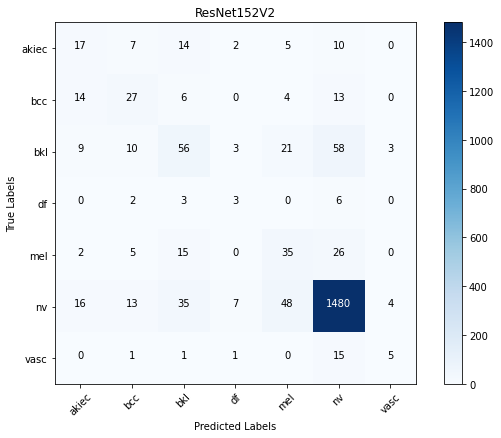

In [30]:
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
create_confusion_matrix(test_labels, predictions1, cm_plot_labels, model1_name)
create_confusion_matrix(test_labels, predictions2, cm_plot_labels, model2_name)
create_confusion_matrix(test_labels, predictions3, cm_plot_labels, model3_name)
create_confusion_matrix(test_labels, predictions4, cm_plot_labels, model4_name)

#Plot model accuracy + loss

In [31]:
def plot_model_history(model_history, name):
    
    fig = plt.figure()

    #Summarize history for accuracy
    ax1 = plt.subplot(1,2,1) 
    ax1.plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    ax1.plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    ax1.legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    ax2 = plt.subplot(1,2,2) 
    ax2.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    ax2.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    ax2.legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('/content/drive/MyDrive/Datasets/Photos/' + name + '_model_history.png', dpi=300)

#Summarize Models Accuracy and Loss against Epochs

In [33]:
plot_model_history(history1, model1_name)
plot_model_history(history2, model2_name)
plot_model_history(history3, model3_name)
plot_model_history(history4, model4_name)